# RL Stock Trading using DQN
# This notebook runs on Google Colab. It implements a custom Gym environment for single-stock trading,
# computes common indicators, trains a DQN agent, and evaluates performance.


In [4]:
!pip install --quiet yfinance gym==0.25.2 torch torchvision torchaudio pandas numpy matplotlib

# %%
import yfinance as yf
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.3 MB/s eta 0:00:00


In [7]:
def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%

def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    # RSI calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # Back-fill NaN values
    df.bfill(inplace=True)
    return df


In [8]:
class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)

        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)
        # Observation: [close, SMA, EMA, RSI, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, 0, 0], dtype=np.float32)
        obs_high = np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(),
            row['SMA'].item(),
            row['EMA'].item(),
            row['RSI'].item(),
            float(self.shares_held),
            float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        if action == 1:  # buy
            if self.balance >= price:
                self.shares_held += 1
                self.balance -= price
        elif action == 2:  # sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += price

        self.current_step += 1
        done = self.current_step >= self.max_steps
        row_next = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * row_next['Close'].item()
        reward = self.net_worth - prev_net_worth

        obs = self._get_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")


In [9]:
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [10]:
# %%
# Hyperparameters
episode_count = 50
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

env = TradingEnv(df, initial_balance=10000, max_steps=200)

# Init networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps_threshold:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = policy_net(state_v)
        return q_values.argmax().item()

for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learn from experience
        if len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
            action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

            q_values = policy_net(state_batch).gather(1, action_batch)
            next_q_values = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
            expected_q = reward_batch + (gamma * next_q_values * (1 - done_batch))

            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")


[*********************100%***********************]  1 of 1 completed
<ipython-input-8-2692653620>:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['Close']),
<ipython-input-8-2692653620>:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['SMA']),
<ipython-input-8-2692653620>:30: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['EMA']),
<ipython-input-8-2692653620>:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['RSI']),


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
state = env.reset()
values = []
s = state
for _ in range(env.max_steps):
    action = policy_net(
        torch.tensor(s, dtype=torch.float32)
               .unsqueeze(0).to(device)
    ).argmax().item()
    s, _, done, _ = env.step(action)
    values.append(env.net_worth)
    if done:
        break

# Generate buy‑and‑hold values for the same number of steps:
bh_prices = df['Close'].iloc[:len(values)].values
bh_values  = bh_prices / bh_prices[0] * env.initial_balance

# Plot both on a shared 0–N axis:
plt.figure(figsize=(10, 5))
plt.plot(range(len(values)), values, label='DQN Portfolio Value')
plt.plot(range(len(bh_values)), bh_values, label='Buy and Hold')
plt.legend()
plt.title('Portfolio Value Over Time (aligned steps)')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.show()


In [ ]:
//////////////////

[*********************100%***********************]  1 of 1 completed


Episode 1/500, Total Reward: 228.84
Episode 2/500, Total Reward: 18.99
Episode 3/500, Total Reward: 8.22
Episode 4/500, Total Reward: 138.86
Episode 5/500, Total Reward: 18.74
Episode 6/500, Total Reward: 51.46
Episode 7/500, Total Reward: 65.35
Episode 8/500, Total Reward: 104.40
Episode 9/500, Total Reward: 72.94
Episode 10/500, Total Reward: 70.12
Episode 11/500, Total Reward: 184.54
Episode 12/500, Total Reward: 129.84
Episode 13/500, Total Reward: 225.43
Episode 14/500, Total Reward: -3.74
Episode 15/500, Total Reward: -74.34
Episode 16/500, Total Reward: -8.50
Episode 17/500, Total Reward: 119.63
Episode 18/500, Total Reward: 266.52
Episode 19/500, Total Reward: 88.54
Episode 20/500, Total Reward: 143.06
Episode 21/500, Total Reward: 276.28
Episode 22/500, Total Reward: 109.40
Episode 23/500, Total Reward: 29.55
Episode 24/500, Total Reward: 125.69
Episode 25/500, Total Reward: 135.35
Episode 26/500, Total Reward: 192.05
Episode 27/500, Total Reward: 117.44
Episode 28/500, Total 

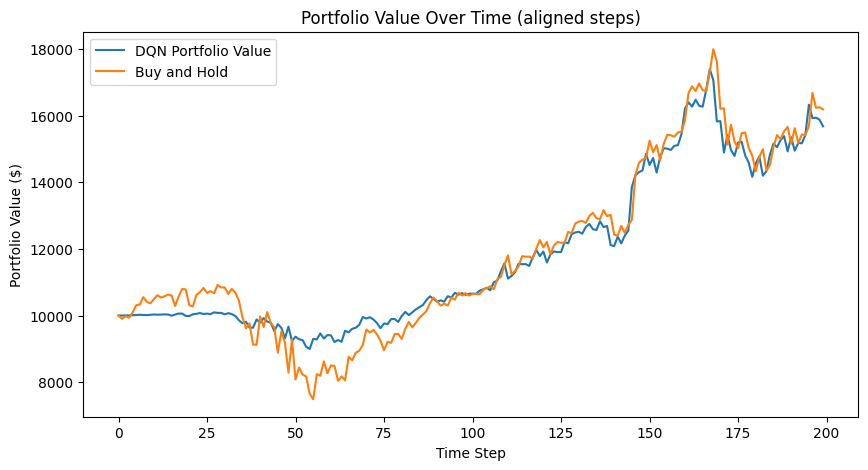

In [14]:


def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%

def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    # RSI calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # Back-fill NaN values
    df.bfill(inplace=True)
    return df


# %%
class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)

        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)
        # Observation: [close, SMA, EMA, RSI, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, 0, 0], dtype=np.float32)
        obs_high = np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(),
            row['SMA'].item(),
            row['EMA'].item(),
            row['RSI'].item(),
            float(self.shares_held),
            float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        if action == 1:  # buy
            if self.balance >= price:
                self.shares_held += 1
                self.balance -= price
        elif action == 2:  # sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += price

        self.current_step += 1
        done = self.current_step >= self.max_steps
        row_next = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * row_next['Close'].item()
        reward = self.net_worth - prev_net_worth

        obs = self._get_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")


# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



# %%
# Hyperparameters
episode_count = 500
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

env = TradingEnv(df, initial_balance=10000, max_steps=200)

# Init networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps_threshold:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = policy_net(state_v)
        return q_values.argmax().item()

for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learn from experience
        if len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
            action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

            q_values = policy_net(state_batch).gather(1, action_batch)
            next_q_values = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
            expected_q = reward_batch + (gamma * next_q_values * (1 - done_batch))

            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")



# %%
state = env.reset()
values = []
s = state
for _ in range(env.max_steps):
    action = policy_net(
        torch.tensor(s, dtype=torch.float32)
               .unsqueeze(0).to(device)
    ).argmax().item()
    s, _, done, _ = env.step(action)
    values.append(env.net_worth)
    if done:
        break

# Generate buy‑and‑hold values for the same number of steps:
bh_prices = df['Close'].iloc[:len(values)].values
bh_values  = bh_prices / bh_prices[0] * env.initial_balance

# Plot both on a shared 0–N axis:
plt.figure(figsize=(10, 5))
plt.plot(range(len(values)), values, label='DQN Portfolio Value')
plt.plot(range(len(bh_values)), bh_values, label='Buy and Hold')
plt.legend()
plt.title('Portfolio Value Over Time (aligned steps)')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.show()




# ## End of Notebook
# You can now experiment with parameters, different stocks, or add more indicators!


[*********************100%***********************]  1 of 1 completed


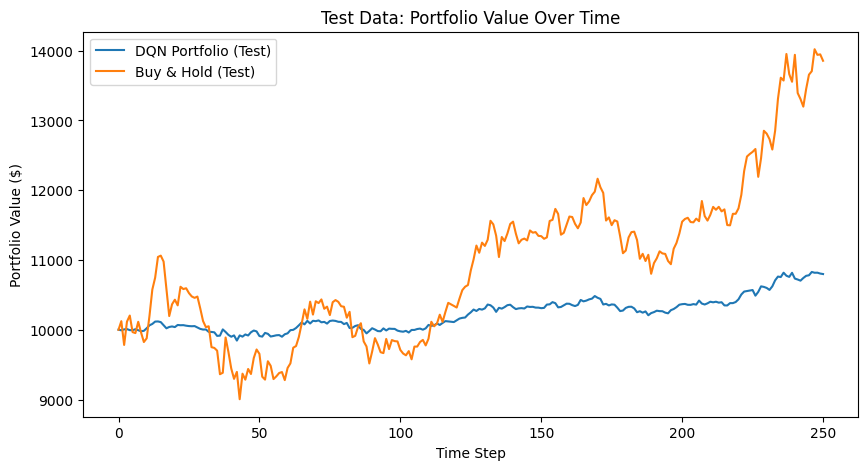

In [18]:
# Fetch and prepare unseen test data
df_test = fetch_data('AAPL', '2021-01-02', '2022-01-01')
df_test = add_indicators(df_test)
# Create new test environment
env_test = TradingEnv(df_test, initial_balance=10000, max_steps=len(df_test)-1)

# Run greedy policy on test environment
state = env_test.reset()
values_test = []
s = state
for _ in range(env_test.max_steps):
    action = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env_test.step(action)
    values_test.append(env_test.net_worth)
    if done:
        break

# Plot test performance
plt.figure(figsize=(10, 5))
plt.plot(range(len(values_test)), values_test, label='DQN Portfolio (Test)')
bh_test = df_test['Close'].iloc[:len(values_test)].values
bh_values_test = bh_test / bh_test[0] * env_test.initial_balance
plt.plot(range(len(bh_values_test)), bh_values_test, label='Buy & Hold (Test)')
plt.legend()
plt.title('Test Data: Portfolio Value Over Time')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.show()


# This model is very conservative and holds which should be improved

In [19]:
actions = []
state = env_test.reset()
for _ in range(env_test.max_steps):
    action = policy_net(torch.tensor(state, dtype=torch.float32)
                        .unsqueeze(0).to(device)).argmax().item()
    actions.append(action)
    state, _, done, _ = env_test.step(action)
    if done: break

print("Action counts:", {a: actions.count(a) for a in set(actions)})


Action counts: {0: 230, 1: 16, 2: 5}


#Add a small penalty for each trade to discourage inaction‑only policies, or a bonus for correctly timed trades

[*********************100%***********************]  1 of 1 completed


Episode 1/300, Total Reward: 285.78
Episode 2/300, Total Reward: 128.02
Episode 3/300, Total Reward: -3.11
Episode 4/300, Total Reward: -49.03
Episode 5/300, Total Reward: 107.64
Episode 6/300, Total Reward: 38.64
Episode 7/300, Total Reward: 42.72
Episode 8/300, Total Reward: 62.28
Episode 9/300, Total Reward: 37.31
Episode 10/300, Total Reward: -0.99
Episode 11/300, Total Reward: 45.03
Episode 12/300, Total Reward: 124.99
Episode 13/300, Total Reward: 82.85
Episode 14/300, Total Reward: 22.20
Episode 15/300, Total Reward: -2.19
Episode 16/300, Total Reward: 101.48
Episode 17/300, Total Reward: 28.41
Episode 18/300, Total Reward: 71.37
Episode 19/300, Total Reward: 7.99
Episode 20/300, Total Reward: 15.56
Episode 21/300, Total Reward: 82.15
Episode 22/300, Total Reward: 49.94
Episode 23/300, Total Reward: -6.91
Episode 24/300, Total Reward: 48.44
Episode 25/300, Total Reward: 16.17
Episode 26/300, Total Reward: 5.06
Episode 27/300, Total Reward: 48.42
Episode 28/300, Total Reward: 109

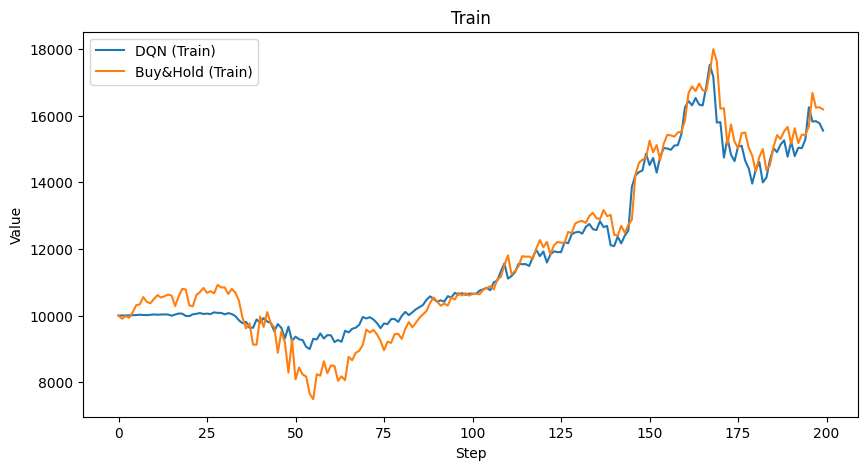

[*********************100%***********************]  1 of 1 completed


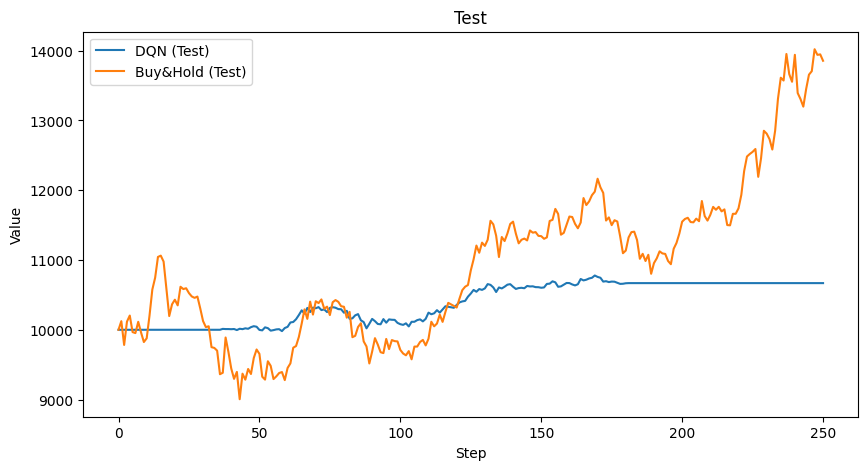

In [20]:

# ## 2. Data Fetching and Indicator Computation

# %%

def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%

def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    # RSI calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.bfill(inplace=True)
    return df

# ## 3. Define Trading Environment with Reward Shaping

# %%
class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading with trade penalty"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, trade_penalty=0.1):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.trade_penalty = trade_penalty

        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)
        # Observation: [close, SMA, EMA, RSI, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, 0, 0], dtype=np.float32)
        obs_high= np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(), row['SMA'].item(), row['EMA'].item(), row['RSI'].item(),
            float(self.shares_held), float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        trade_cost = 0.0
        if action == 1 and self.balance >= price:
            self.shares_held += 1
            self.balance -= price
            trade_cost = self.trade_penalty
        elif action == 2 and self.shares_held > 0:
            self.shares_held -= 1
            self.balance += price
            trade_cost = self.trade_penalty

        self.current_step += 1
        done = self.current_step >= self.max_steps
        row_next = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * row_next['Close'].item()

        # Reward = change in net worth minus trade penalty
        reward = (self.net_worth - prev_net_worth) - trade_cost

        obs = self._get_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")


# ## 4. Define DQN Agent

# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    def push(self, *args): self.memory.append(Transition(*args))
    def sample(self, batch_size): return random.sample(self.memory, batch_size)
    def __len__(self): return len(self.memory)


# ## 5. Training Loop

# %%
# Hyperparameters
episode_count = 300
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

# Use reward shaping penalty=0.1
env = TradingEnv(df, initial_balance=10000, max_steps=200, trade_penalty=0.1)

# Init networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()
steps_done = 0

def select_action(state):
    global steps_done
    eps = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        return policy_net(state_v).argmax().item()

for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if len(memory) >= batch_size:
            batch = Transition(*zip(*random.sample(memory.memory, batch_size)))
            s_b = torch.tensor(batch.state, dtype=torch.float32).to(device)
            a_b = torch.tensor(batch.action).unsqueeze(1).to(device)
            r_b = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            ns_b= torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            d_b = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)
            q = policy_net(s_b).gather(1, a_b)
            qn= target_net(ns_b).max(1)[0].detach().unsqueeze(1)
            y = r_b + gamma * qn * (1 - d_b)
            loss = nn.MSELoss()(q, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        if done: break
    if episode % target_update == 0: target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")


# ## 6. Evaluation on Training Data

# %%
state = env.reset(); values = []; s = state
for _ in range(env.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env.step(a); values.append(env.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(values)), values, label='DQN (Train)')
bh = df['Close'].iloc[:len(values)].values; bhv = bh/bh[0]*env.initial_balance
plt.plot(range(len(bhv)), bhv, label='Buy&Hold (Train)'); plt.legend(); plt.title('Train'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()


# ## 7. Evaluation on Test Data

# %%
df_test = fetch_data('AAPL', '2021-01-02', '2022-01-01'); df_test = add_indicators(df_test)
env_test = TradingEnv(df_test, initial_balance=10000, max_steps=len(df_test)-1, trade_penalty=0.1)
state = env_test.reset(); values_test = []; s = state
for _ in range(env_test.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env_test.step(a); values_test.append(env_test.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(values_test)), values_test, label='DQN (Test)')
bht = df_test['Close'].iloc[:len(values_test)].values; bhtv = bht/bht[0]*env_test.initial_balance
plt.plot(range(len(bhtv)), bhtv, label='Buy&Hold (Test)'); plt.legend(); plt.title('Test'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()


3stil not taing risks

[*********************100%***********************]  1 of 1 completed


Episode 1/500, Total Reward: 179.92
Episode 2/500, Total Reward: 26.73
Episode 3/500, Total Reward: 4.71
Episode 4/500, Total Reward: 86.03
Episode 5/500, Total Reward: 215.74
Episode 6/500, Total Reward: 78.44
Episode 7/500, Total Reward: -44.17
Episode 8/500, Total Reward: 26.37
Episode 9/500, Total Reward: 10.49
Episode 10/500, Total Reward: 12.53
Episode 11/500, Total Reward: 206.96
Episode 12/500, Total Reward: 31.05
Episode 13/500, Total Reward: 29.14
Episode 14/500, Total Reward: -24.37
Episode 15/500, Total Reward: 29.35
Episode 16/500, Total Reward: 30.37
Episode 17/500, Total Reward: -1.59
Episode 18/500, Total Reward: 33.28
Episode 19/500, Total Reward: 17.60
Episode 20/500, Total Reward: 185.85
Episode 21/500, Total Reward: 5.54
Episode 22/500, Total Reward: 412.84
Episode 23/500, Total Reward: 129.35
Episode 24/500, Total Reward: 16.37
Episode 25/500, Total Reward: 118.82
Episode 26/500, Total Reward: 46.52
Episode 27/500, Total Reward: 94.70
Episode 28/500, Total Reward: 

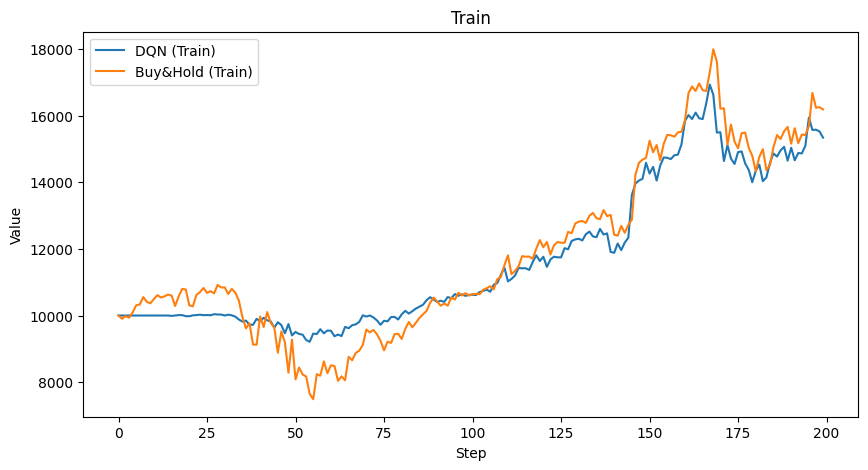

In [6]:

# ## 2. Data Fetching and Indicator Computation


def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df



def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14):
    df['SMA'] = df['Close'].rolling(window=window_sma).mean()
    df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()
    # RSI calculation
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    # New return features
    df['Ret1'] = df['Close'].pct_change(1)
    df['Ret5'] = df['Close'].pct_change(5)
    df.bfill(inplace=True)
    return df


## 3. ## 3. Define Trading Environment with Reward Shaping and Enhanced State

# %%
class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading with trade penalty and added return features"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, trade_penalty=0.1):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.trade_penalty = trade_penalty

        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)

        # Observation: [Close, SMA, EMA, RSI, Ret1, Ret5, holdings, cash]
        obs_low = np.array([0, 0, 0, 0, -1, -1, 0, 0], dtype=np.float32)
        obs_high= np.array([np.inf, np.inf, np.inf, 100, 1, 1, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        return np.array([
            row['Close'].item(),
            row['SMA'].item(),
            row['EMA'].item(),
            row['RSI'].item(),
            row['Ret1'].item(),
            row['Ret5'].item(),
            float(self.shares_held),
            float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action with penalty
        trade_cost = 0.0
        if action == 1 and self.balance >= price:
            self.shares_held += 1
            self.balance -= price
            trade_cost = self.trade_penalty
        elif action == 2 and self.shares_held > 0:
            self.shares_held -= 1
            self.balance += price
            trade_cost = self.trade_penalty

        self.current_step += 1
        done = self.current_step >= self.max_steps
        row_next = self.df.loc[self.current_step]
        self.net_worth = self.balance + self.shares_held * row_next['Close'].item()

        reward = (self.net_worth - prev_net_worth) - trade_cost
        obs = self._get_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")

## 4. Define DQN Agent Define DQN Agent

# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    def push(self, *args): self.memory.append(Transition(*args))
    def sample(self, batch_size): return random.sample(self.memory, batch_size)
    def __len__(self): return len(self.memory)


# ## 5. Training Loop

# %%
# Hyperparameters
episode_count = 500
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

# Use reward shaping penalty=0.1
env = TradingEnv(df, initial_balance=10000, max_steps=200, trade_penalty=0.1)

# Init networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()
steps_done = 0

def select_action(state):
    global steps_done
    eps = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        return policy_net(state_v).argmax().item()

for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if len(memory) >= batch_size:
            batch = Transition(*zip(*random.sample(memory.memory, batch_size)))
            s_b = torch.tensor(batch.state, dtype=torch.float32).to(device)
            a_b = torch.tensor(batch.action).unsqueeze(1).to(device)
            r_b = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            ns_b= torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            d_b = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)
            q = policy_net(s_b).gather(1, a_b)
            qn= target_net(ns_b).max(1)[0].detach().unsqueeze(1)
            y = r_b + gamma * qn * (1 - d_b)
            loss = nn.MSELoss()(q, y)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        if done: break
    if episode % target_update == 0: target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")


# ## 6. Evaluation on Training Data

# %%
state = env.reset(); values = []; s = state
for _ in range(env.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env.step(a); values.append(env.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(values)), values, label='DQN (Train)')
bh = df['Close'].iloc[:len(values)].values; bhv = bh/bh[0]*env.initial_balance
plt.plot(range(len(bhv)), bhv, label='Buy&Hold (Train)'); plt.legend(); plt.title('Train'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()




[*********************100%***********************]  1 of 1 completed


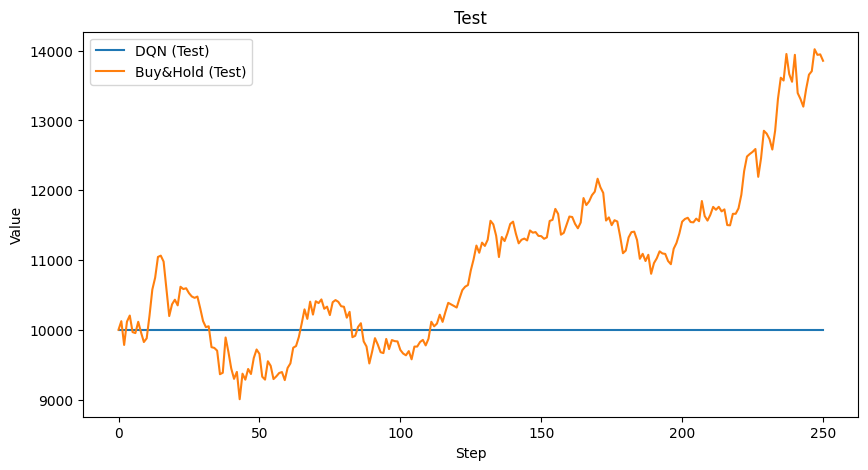

In [8]:
# ## 7. Evaluation on Test Data

# %%
df_test = fetch_data('AAPL', '2021-01-02', '2022-01-01'); df_test = add_indicators(df_test)
env_test = TradingEnv(df_test, initial_balance=10000, max_steps=len(df_test)-1, trade_penalty=0.1)
state = env_test.reset(); values_test = []; s = state
for _ in range(env_test.max_steps):
    a = policy_net(torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
    s, _, done, _ = env_test.step(a); values_test.append(env_test.net_worth)
    if done: break
plt.figure(figsize=(10,5))
plt.plot(range(len(values_test)), values_test, label='DQN (Test)')
bht = df_test['Close'].iloc[:len(values_test)].values; bhtv = bht/bht[0]*env_test.initial_balance
plt.plot(range(len(bhtv)), bhtv, label='Buy&Hold (Test)'); plt.legend(); plt.title('Test'); plt.xlabel('Step'); plt.ylabel('Value'); plt.show()


In [9]:
actions = []
state = env_test.reset()
for _ in range(env_test.max_steps):
    action = policy_net(torch.tensor(state, dtype=torch.float32)
                        .unsqueeze(0).to(device)).argmax().item()
    actions.append(action)
    state, _, done, _ = env_test.step(action)
    if done: break

print("Action counts:", {a: actions.count(a) for a in set(actions)})


Action counts: {2: 251}
